In [1]:
#import libraries
import json
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
from PIL import Image
from osgeo import gdal
import sys
from skimage import measure
import cv2
from scipy.spatial.distance import directed_hausdorff
from skimage import metrics
import scipy.linalg as la
import copy

In [2]:
#converse origin to lat and long
origin = 90/(2.45388e6)

In [3]:
#GDAL to obtain reference coordination of TIFF image
#img = np.asarray(Image.open("one_band_wgs.tif"))
#ds = gdal.Open("one_band_wgs.tif")
img = np.asarray(Image.open("complex.tif"))
ds = gdal.Open("complex.tif")
width = ds.RasterXSize
height = ds.RasterYSize
gt = ds.GetGeoTransform()
minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5] 
maxx = gt[0] + width*gt[1] + height*gt[2]
maxy = gt[3]

pixx= gt[1]
pixy= -gt[5]

print("size of the image is", np.shape(img))
print("minimum and maximum points are", minx, miny, maxx, maxy)
print(gt)

size of the image is (1000, 2400)
minimum and maximum points are 125.7491532952112 5.539443731622747 179.77491287864729 28.05017689138778
(125.7491532952112, 0.022510733159765036, 0.0, 28.05017689138778, 0.0, -0.022510733159765033)


In [4]:
x2=[]
y2=[]
for i in range(len(img[:,0])):
    for j in range(len(img[0,:])):
        if img[i,j]>0:
            x2.append(j)
            y2.append(i)
xx=np.array(x2)
yy=np.array(y2)
#xx yy has True info

In [5]:
#plt.imshow(img, cmap='gray')
#plt.scatter(xx,yy,alpha=0.1,s=0.1)
#newimg 1 is x and 0 is y

In [6]:
n=16

In [7]:
dist_plus=np.zeros([len(xx),n,2])
dist_minus=np.zeros([len(xx),n,2])
for m in range(n):
    r = math.tan(math.pi/n*m)
    for i in range(len(xx)):
        j=0
        c=img[yy[i],xx[i]]
        if r==0:
            while c!=0:
                a=xx[i]+j
                b=yy[i]
                c=img[b,a]
                j+=1
        elif r**2>10e10:
            while c!=0:
                a=xx[i]
                b=yy[i]-j
                c=img[b,a]
                j+=1
        else:
            while c!=0:
                a=xx[i]+j
                b=-r*(a-xx[i])+yy[i]
                c=img[int(b),a]
                j+=1
        dist_plus[i,m,:]=[a*pixx+minx,((maxy-miny)/pixy-b)*pixy+miny]
    
        k=0
        c=img[yy[i],xx[i]]
        if r==0:
            while c!=0:
                d=xx[i]-k
                e=yy[i]
                c=img[e,d]
                k+=1
        elif r**2>10e10:
            while c!=0:
                d=xx[i]
                e=yy[i]+k
                c=img[e,d]
                k+=1
        else:
            while c!=0:
                d=xx[i]-k
                e=-r*(d-xx[i])+yy[i]
                c=img[int(e),d]
                k+=1
        dist_minus[i,m,:]=[d*pixx+minx,((maxy-miny)/pixy-e)*pixy+miny]
    print(r)

0.0
0.19891236737965798
0.4142135623730951
0.6681786379192989
0.9999999999999999
1.496605762665489
2.4142135623730945
5.027339492125847
1.633123935319537e+16
-5.027339492125849
-2.4142135623730954
-1.49660576266549
-1.0000000000000002
-0.6681786379192987
-0.41421356237309515
-0.19891236737965834


In [8]:
#calculating width between plus minus
lplus = dist_plus
lminus = dist_minus

width=np.zeros([len(xx),n])
for j in range(n):
    for i in range(len(lplus)):
        a = math.cos((90 - lplus[i,j,1]) / 180 * math.pi)
        b = math.cos((90 - lminus[i,j,1]) / 180 * math.pi)
        c = math.sin((90 - lplus[i,j,1]) / 180 * math.pi)
        d = math.sin((90 - lminus[i,j,1]) / 180 * math.pi)
        e = math.cos((lminus[i,j,0] - lplus[i,j,0]) / 180 * math.pi)
        f = a * b + c * d * e
        length = math.acos(f) * 1560800
        width[i,j]=np.array(length)

In [9]:
tag=np.zeros([len(xx)])
for i in range(len(xx)):
    argmaxx=[]
    loc=np.array([0,0])
    for j in range(n):
        calcul=width[i,j]/width[i,j-int(n/2)]
        argmaxx.append(calcul)
    k = argmaxx.index(max(argmaxx))
    loc=k
    tag[i]=int(loc)
#print(tag)    

In [10]:
rwidth = []
for i in range(len(xx)):
    rwidth.append(width[i,int(tag[i]-int(n/2))])
realw=np.array(rwidth)
#print(realw)

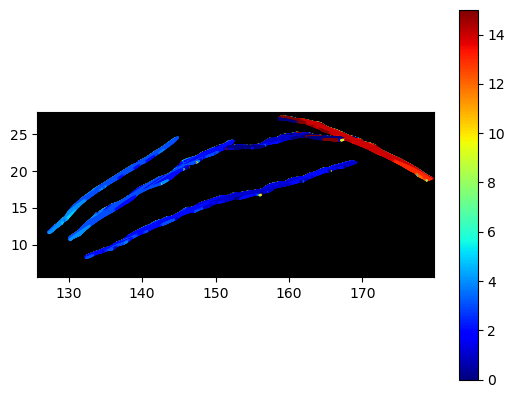

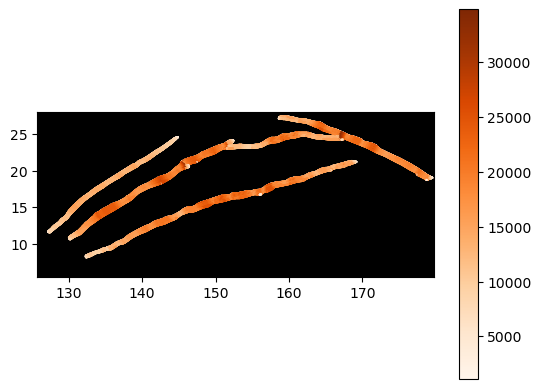

In [11]:
plt.imshow(img, extent=[minx,maxx,miny,maxy],cmap='gray')
plt.scatter(xx*pixx+minx,((maxy-miny)/pixy-yy)*pixy+miny,c=tag,s=0.2,alpha=1,cmap='jet')
plt.colorbar()

plt.figure()
plt.imshow(img, extent=[minx,maxx,miny,maxy],cmap='gray')
plt.scatter(xx*pixx+minx,((maxy-miny)/pixy-yy)*pixy+miny,c=realw,s=0.2,alpha=1,cmap='Oranges')
plt.colorbar()
#argmax is finished

In [12]:
#Denosing

In [13]:
#Connected-component labeling method
cclm=np.zeros([len(img[:,0]),len(img[0,:])])
for i in range(len(yy)):
    cclm[yy[i],xx[i]]=tag[i]+1

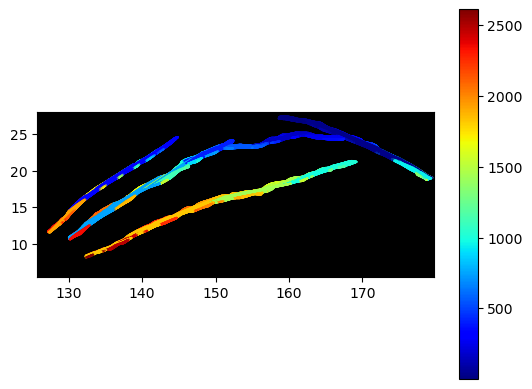

In [14]:
#making labels
blabels = measure.label(cclm, background=0)
plt.imshow(img, extent=[minx,maxx,miny,maxy],cmap='gray')
plt.scatter(xx*pixx+minx,((maxy-miny)/pixy-yy)*pixy+miny,c=blabels[img>0].ravel(),s=0.2,alpha=1,cmap='jet')
plt.colorbar()

In [15]:
#Hausdorff distance method

In [16]:
#ordering labels from largest to smallest
order=np.zeros(max(blabels.ravel()))
lab = np.arange(0,max(blabels.ravel()))+1
for i in range(len(xx)):
    j = blabels[yy[i],xx[i]]
    if j > 0:
        order[j-1]+=1
#print(order)
for i in range(len(order)):
    for j in range(len(order)):
        if order[j]<order[i]:
            a = order[i]
            b = order[j]
            c = lab[i]
            d = lab[j]
            order[j]=a
            order[i]=b
            lab[j]=c
            lab[i]=d

In [17]:
# Th(threshold) is mean width of group
# Mean width per labels
mwid=np.zeros([len(img[:,0]),len(img[0,:])])
for i in range(len(yy)):
    mwid[yy[i],xx[i]]=realw[i]
meanw=[]
for i in range(len(lab)):
    a=mwid[blabels==lab[i]]
    b=np.mean(a)
    meanw.append(b)
meanw=np.array(meanw)   

In [18]:
kernel = np.ones((3, 3), np.uint8) 

In [19]:
lab2 = np.array(lab)
meanw2 = np.array(meanw)
blabels2 = np.array(blabels)
for i in range(len(lab2)-1):
    if lab2[i]!=0:
        for j in range(i+1,len(lab2)):
            if lab2[j]!=0:
                maxr=[]
                locr=[]
                #Finding neighbor
                testa = np.zeros([len(img[:,0]),len(img[0,:])])+(blabels2==lab2[i])
                img_dilation = cv2.dilate(testa, kernel, iterations=1)
                testaj = np.zeros([len(img[:,0]),len(img[0,:])])+(blabels2==lab2[j])
                img_erosion = cv2.erode(testa, kernel, iterations=1) 
                outline = testa-img_erosion
                neighbor = img_dilation+testaj
                if sum(sum(neighbor==2))>0:
                    #Calculate Hausdorff distance
                    a,b = xx[np.array([outline[img>0]>0]).ravel()], yy[np.array([outline[img>0]>0]).ravel()]
                    c,d = xx[blabels2[img>0].ravel()==lab2[j]], yy[blabels2[img>0].ravel()==lab2[j]]
                    for k in range(len(xx[blabels2[img>0].ravel()==lab2[j]])):
                        maxcan=[]
                        loccan=[]
                        for l in range(len(xx[np.array([outline[img>0]>0]).ravel()])):
                            r=math.sqrt((a[l]-c[k])**2+(b[l]-d[k])**2)
                            maxcan.append(r)
                            loccan.append([a[l],b[l],c[k],d[k]])
                        maxr.append(min(maxcan))
                        locr.append(loccan[maxcan.index(min(maxcan))])
                    hd=max(maxr)
                    if hd <5:
                        blabels2[blabels2==lab[j]]=lab[i]
                        lab2[j]=0
                        continue
                    locd= locr[maxr.index(max(maxr))]
                    a = math.cos((90 - (((maxy-miny)/pixy-locd[1])*pixy+miny)) / 180 * math.pi)
                    b = math.cos((90 - (((maxy-miny)/pixy-locd[3])*pixy+miny)) / 180 * math.pi)
                    c = math.sin((90 - (((maxy-miny)/pixy-locd[1])*pixy+miny)) / 180 * math.pi)
                    d = math.sin((90 - (((maxy-miny)/pixy-locd[3])*pixy+miny)) / 180 * math.pi)
                    e = math.cos(((locd[2]*pixx+minx) - (locd[0]*pixx+minx)) / 180 * math.pi)
                    f = a * b + c * d * e
                    h = math.acos(f) * 1562090
                    if h < meanw2[i]:
                        blabels2[blabels2==lab[j]]=lab[i]
                        lab2[j]=0
lab3 = np.delete(lab2,lab2==0)

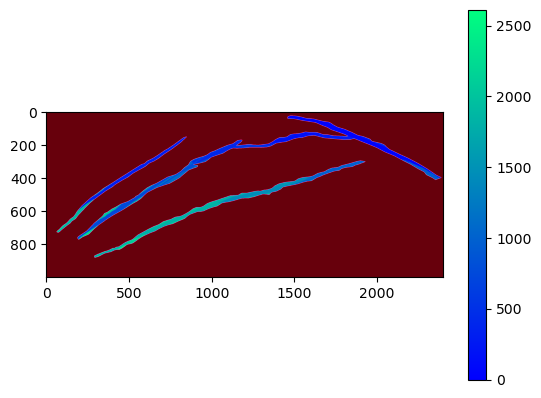

In [20]:
#plt.imshow(img)
w=lab2[8]
plt.imshow(blabels, cmap='winter')
plt.colorbar()
plt.imshow(blabels2==w,alpha=(blabels2==w)/1, cmap="Reds")
#plt.savefig("label.png")

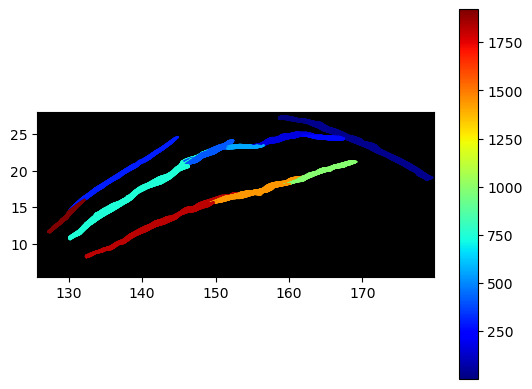

In [21]:
plt.imshow(img, extent=[minx,maxx,miny,maxy],cmap='gray')
plt.scatter(xx*pixx+minx,((maxy-miny)/pixy-yy)*pixy+miny,c=blabels2[img>0].ravel(),s=0.1,alpha=1,cmap='jet')
plt.colorbar()

In [22]:
#Making new labels with narrowed down groups
newlab=np.array(blabels2)
for i in range(len(lab3)):
    newlab[blabels2==lab3[i]]=i+1

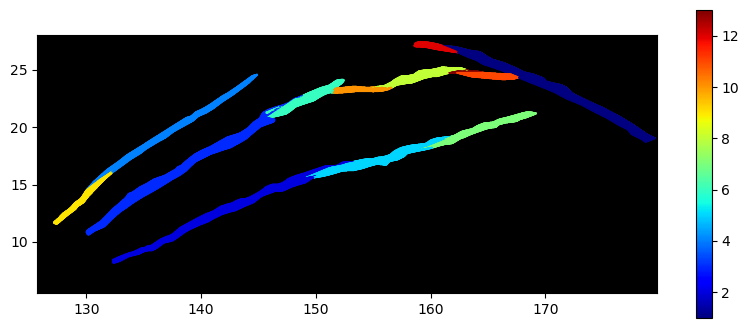

In [23]:
plt.figure(figsize=(10,4))
plt.imshow(img, extent=[minx,maxx,miny,maxy],cmap='gray')
plt.scatter(xx*pixx+minx,((maxy-miny)/pixy-yy)*pixy+miny,c=newlab[img>0].ravel(),s=0.1,alpha=1,cmap='jet')
plt.colorbar()
plt.savefig("newlabel.png",dpi=800)

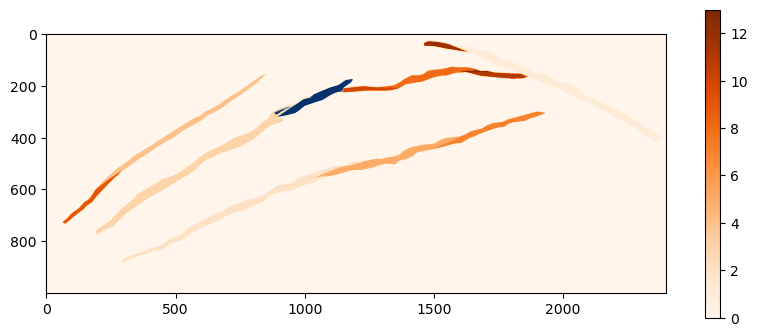

In [24]:
#plt.imshow(img)
plt.figure(figsize=[10,4])
w=6
v=14
plt.imshow(newlab, cmap='Oranges')
plt.colorbar()
plt.imshow(newlab==w,alpha=(newlab==w)/1, cmap="Blues")
plt.imshow(newlab==v,alpha=(newlab==v)/1, cmap="Greens")
#plt.savefig("label4.png")

In [25]:
# New mean width
nmeanw=[]
for i in range(max(newlab.ravel())):
    a=mwid[newlab==i+1]
    b=np.median(a)
    print(b)
    nmeanw.append(b)
nmeanw=np.array(nmeanw)  
print(np.shape(nmeanw))

18971.740624413294
17567.995971163513
19113.890211213366
13013.65102342927
20236.164622839653
20601.51573011914
14306.801423515004
18796.717659770504
11963.721816274552
11651.125085843709
13490.776415222945
12524.061440158805
13490.776415202896
(13,)


In [26]:
# New Rotational tag
ntag=[]
cclm2=np.array(cclm)
for i in range(max(newlab.ravel())):
    a=cclm[newlab==i+1]
    b=np.mean(a)
    ntag.append(b)
    cclm2[newlab==i+1]=b
ntag=np.array(ntag)
print(ntag)

[14.54651841  3.23027918  3.97848214  4.18223354  2.31795258  3.19627729
  2.89420907  2.8312381   5.01122566  1.3184375   5.21758122 13.7070546
  1.38372093]


In [27]:
#Continuity Grouping
gam=[]
n2=max(newlab.ravel())
for i in range(n2):
    a,b = xx[newlab[img>0].ravel()==i+1], yy[newlab[img>0].ravel()==i+1]
    X = np.stack((a, b), axis=0)
    cov = np.cov(X)
    w, v = la.eig(cov)
    #print(w)
    gam.append(w[0]/(w[0]+w[1]))
print(gam)

[(0.9977780653858963+0j), (0.998491368674457+0j), (0.9976899397303344+0j), (0.999129338334875+0j), (0.9959880757412977+0j), (0.9899774103010353+0j), (0.9965702149205533+0j), (0.9901345279288034+0j), (0.9953168229656006+0j), (0.9927052193093575+0j), (0.9917148978886613+0j), (0.983243052441626+0j), (0.9940821925645666+0j)]


In [28]:
n2=max(newlab.ravel())
newlab2=np.array(newlab)
lab4=np.arange(1,16)
nmeanw2=np.array(nmeanw)
ntag2=np.array(ntag)
#gamc=[]
for i in range(n2-1):
    if lab4[i]!=0:
        j=i+1
        while j < n2:
            if lab4[j]!=0:
                testa = np.zeros([len(img[:,0]),len(img[0,:])])+(newlab2==i+1)
                img_dilation = cv2.dilate(testa, kernel, iterations=1)
                testaj = np.zeros([len(img[:,0]),len(img[0,:])])+(newlab2==j+1)
                img_erosion = cv2.erode(testa, kernel, iterations=1) 
                outline = testa-img_erosion
                neighbor = img_dilation+testaj
                if sum(sum(neighbor==2))>0:
                    a = xx[newlab2[img>0].ravel()==i+1].tolist()+xx[newlab2[img>0].ravel()==j+1].tolist()
                    b = yy[newlab2[img>0].ravel()==i+1].tolist()+yy[newlab2[img>0].ravel()==j+1].tolist()
                    X = np.stack((a, b), axis=0)
                    cov = np.cov(X)
                    w, v = la.eig(cov)
                    gamc=w[0]/(w[0]+w[1])
                    delgam = abs(gamc-gam[i])
                    if delgam<gam[i]*0.002:
                        if abs(nmeanw2[i]-nmeanw2[j])<10000: #width control
                            if int(abs(ntag2[i]-ntag2[j]))==0 or 1 or n-1: #angle control
                                newlab2[newlab==j+1]=i+1
                                lab4[j]=0
                                j=i+1
                            else: j+=1
                        else: j+=1
                    else: j+=1
                else: j+=1
            else: j+=1
lab5 = np.delete(lab4,lab4==0)
            

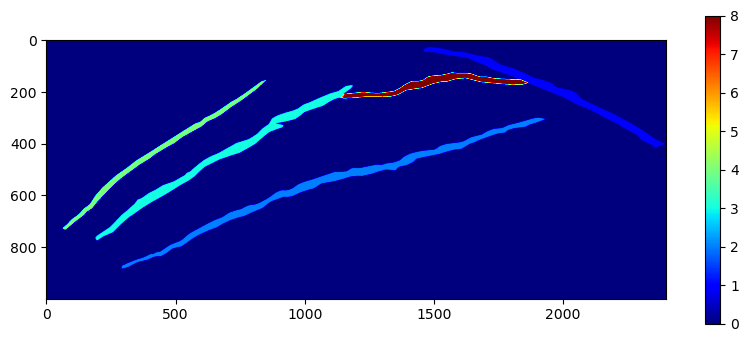

In [29]:
plt.figure(figsize=[10,4])
plt.imshow(newlab2, cmap='jet')
plt.colorbar()

In [30]:
nmeanw2

array([18971.74062441, 17567.99597116, 19113.89021121, 13013.65102343,
       20236.16462284, 20601.51573012, 14306.80142352, 18796.71765977,
       11963.72181627, 11651.12508584, 13490.77641522, 12524.06144016,
       13490.7764152 ])

In [31]:
#Making final labels with narrowed down groups
flab=np.array(newlab2)
for i in range(len(lab5)):
    flab[newlab2==lab5[i]]=i+1

In [32]:
flab

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

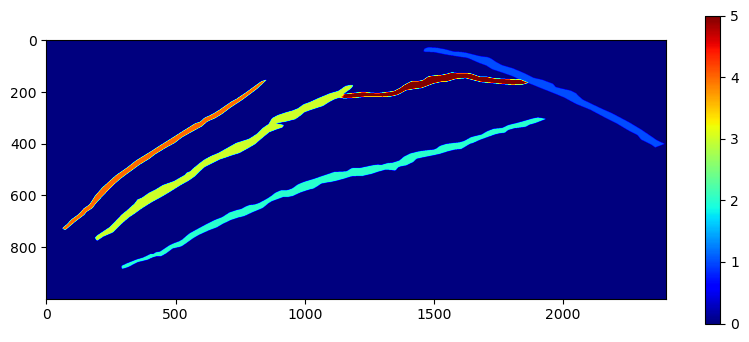

In [33]:
plt.figure(figsize=[10,4])
plt.imshow(flab, cmap='jet')
plt.colorbar()
plt.savefig('finlab.png',dpi=500)

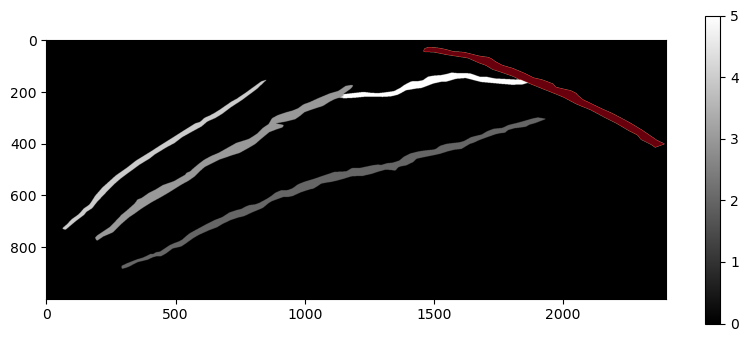

In [34]:
w=1
plt.figure(figsize=[10,4])
plt.imshow(flab, cmap='gray')
plt.colorbar()
plt.imshow(flab==w,alpha=(flab==w)/1, cmap="Reds")
#plt.savefig("label.png")

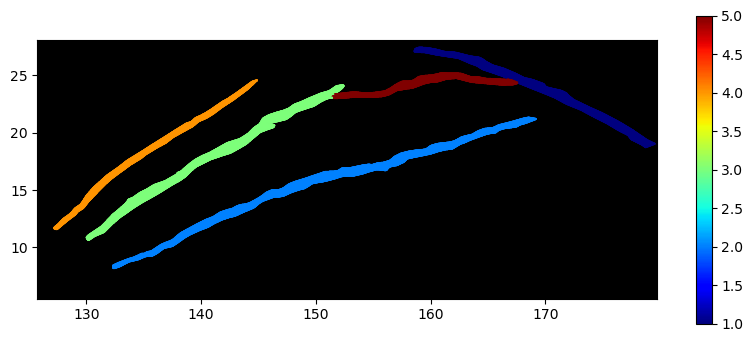

In [35]:
plt.figure(figsize=[10,4])
plt.imshow(img, extent=[minx,maxx,miny,maxy],cmap='gray')
plt.scatter(xx*pixx+minx,((maxy-miny)/pixy-yy)*pixy+miny,c=flab[img>0].ravel(),s=0.1,alpha=1,cmap='jet')
plt.colorbar()
plt.savefig("finallabels.png",dpi=500)

In [36]:
xnew=np.arange(0,np.shape(img)[1])

In [37]:
flab==1

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [38]:
#plt.imshow(img, cmap='gray')
#polynomial regression, initial shaping
f1=[]
f2=[]
pf=[]
for j in range(max(flab.ravel())):
    s1=[]
    s2=[]
    x=xx[flab[img>0].ravel()==j+1]
    y=yy[flab[img>0].ravel()==j+1]
    for i in range(1,16):
        fit = np.polyfit(x, y, i, full=True)
        if i>1:
            if rs<fit[1] or i==15:
                rs=fit[1]
                p=np.poly1d(fit[0])
                break
        else:
            rs=fit[1]
    pf.append(fit[0])
    testa = np.array(flab==j+1)/1
    img_erosion = cv2.erode(testa, np.ones((3, 3), np.uint8) , iterations=2) 
    outline = testa-img_erosion
    plotn=np.array(img)*0
    ynew=p(xnew).astype(int)
    for i in range(len(xnew)):
        if 0<=ynew[i]<np.shape(img)[0]:
            plotn[ynew[i],xnew[i]]=1
    a=np.array(outline+plotn==2)
    for i in range(len(xnew)):
        if i>1 and sum(a)[i-1]==0 and sum(a)[i]>0:
            s1.append(i)
        elif i<len(xnew) and sum(a)[i-1]>0 and sum(a)[i]==0:
            s2.append(i-1)
    f1.append(min(s1))
    f2.append(max(s2))
#print(f1,f2)

/var/folders/hy/p0pxq16943bcq5hl7bzs6q340000gp/T/ipykernel_22137/2825455359.py:14: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if rs<fit[1] or i==15:


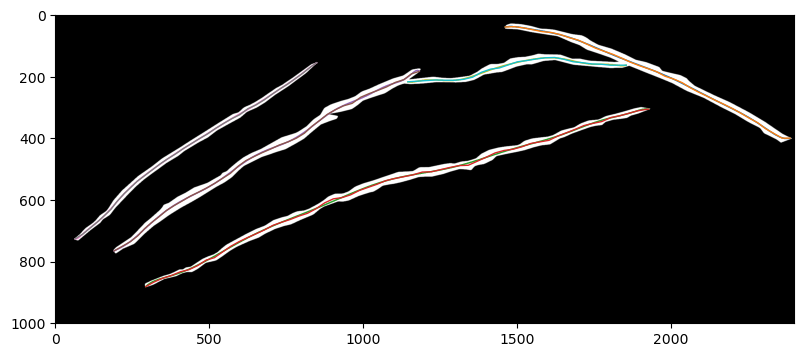

In [39]:
#binning line of polynomial regression
plt.figure(figsize=[10,4])
plt.imshow(img, cmap='gray')
dotd=[] #data in pixels
for j in range(max(flab.ravel())):
    x1=xnew[f1[j]<=xnew]
    x2=x1[x1<=f2[j]]
    pp=np.array(pf)
    p=np.poly1d(pp[j,:])
    y2=p(x2).astype(int)
    plt.plot(x2,y2,lw=1)
    
    xcen=[]
    for i in range(len(x2)):
        if xcen!=[] and max(xcen)>x2[i]:
            continue
        else:
            for k in range(i+1,len(x2)):
                if math.sqrt((x2[i]-x2[k])**2+(y2[i]-y2[k])**2)>30:
                    xcen.append(x2[k])
                    break
    xcen2=np.array([f1[j]]+xcen+[f2[j]])
    ycen =[]
    #print(xcen)
    for i in range(len(xcen)):
        ycent=[]
        for k in range(len(img[:,0])):
            if flab[k,xcen[i]]==j+1:
                ycent.append(k)
        #print(ycent)
        ycent1 = int(np.median(ycent))
        ycen.append(ycent1)
    ycen2=np.array([int(p(f1[j]))]+ycen+[int(p(f2[j]))])
    plt.plot(xcen2,ycen2,lw=1)
    id=j+1
    dotd.append([id, xcen2*pixx+minx,((maxy-miny)/pixy-ycen2)*pixy+miny]) 
    #saving points with lon and lat into list
plt.xlim(0,np.shape(img)[1])
plt.ylim(np.shape(img)[0],0)
plt.show()
#plt.savefig("lines.png",dpi=500)

In [40]:
# Adding lengths of lines
dotd2 = copy.deepcopy(dotd)
for i in range(len(dotd)):
    locd = [dotd[i][1][0], dotd[i][2][0], dotd[i][1][-1], dotd[i][2][-1]]
    a = math.cos((90 - locd[1]) / 180 * math.pi)
    b = math.cos((90 - locd[3]) / 180 * math.pi)
    c = math.sin((90 - locd[1]) / 180 * math.pi)
    d = math.sin((90 - locd[3]) / 180 * math.pi)
    e = math.cos((locd[2] - locd[0]) / 180 * math.pi)
    f = a * b + c * d * e
    l = math.acos(f) * 1562090
    dotd2[i].append(l) #dotd2[][3]=length of straight line
    
    h2=0
    for j in range(len(dotd[i][1])-1):
        locd = [dotd[i][1][j], dotd[i][2][j], dotd[i][1][j+1], dotd[i][2][j+1]]
        a = math.cos((90 - locd[1]) / 180 * math.pi)
        b = math.cos((90 - locd[3]) / 180 * math.pi)
        c = math.sin((90 - locd[1]) / 180 * math.pi)
        d = math.sin((90 - locd[3]) / 180 * math.pi)
        e = math.cos((locd[2] - locd[0]) / 180 * math.pi)
        f = a * b + c * d * e
        h = math.acos(f) * 1562090
        h2+=h
    dotd2[i].append(h2) #dotd2[][4]=length of curve line

In [41]:
# Adding sinuosity
dotd3 = copy.deepcopy(dotd2)
for i in range(len(dotd)):
    a = dotd2[i][3]
    b = dotd2[i][4]
    s = b/a
    dotd3[i].append(s) #dotd3[][5]=add sinuosity

In [42]:
# Strike? as liniear regression
dotd4 = copy.deepcopy(dotd3)
for i in range(len(dotd)):
    x = dotd3[i][1]
    y = dotd3[i][2]
    z1, z2 = np.polyfit(x,y,1)
    s=90-math.atan(z1)*180/math.pi
    dotd4[i].append(s) # dotd4[][6]=Add strike as right-lateral from the azimuth

In [43]:
dotd5

NameError: name 'dotd5' is not defined

In [ ]:
plt.figure(figsize=[10,4])
plt.imshow(img, cmap='gray')
dotd6=[] #data in pixels
for l in range(max(flab.ravel())):
    x1=xnew[f1[l]<=xnew]
    x2=x1[x1<=f2[l]]
    pp=np.array(pf)
    p=np.poly1d(pp[l,:])
    y2=p(x2).astype(int)
    #plt.plot(x2,y2,lw=1)
    
    xcen=[]
    ycen=[]
    for i in range(1,len(x2)-1):
        if xcen!=[] and max(xcen)>x2[i]:
            continue
        else:
            for o in range(i+1,len(x2)):
                if math.sqrt((x2[i]-x2[o])**2+(y2[i]-y2[o])**2)>30:
                    xcen.append(x2[o])
                    ycen.append(y2[o])
                    break

    xcen1=np.array([f1[l]]+xcen+[f2[l]])
    ycen1=np.array([int(p(f1[l]))]+ycen+[int(p(f2[l]))])
    #plt.plot(xcen1,ycen1,lw=1)
    
    #plt.plot(xcen2,ycen2,lw=1)
    
    xcen3=[]
    ycen3 =[]
    #print(xcen)
    bx=xcen
    by=ycen
    p2=np.polyder(p)
    dist_pl=[]
    dist_mi=[]
    for i in range(len(xcen)):
        r2= p2(xcen[i])
        #print(1/r2)
        j=0
        c=flab[by[i],bx[i]]
        if r==0:
            while c==l+1:
                a=bx[i]+j
                b=by[i]
                c=flab[int(b),int(a)]
                j+=1
        elif (1/r)**2<1e2:
            while c==l+1:
                a=bx[i]+j
                b=-1/r2*(j)+by[i]
                c=flab[int(b),int(a)]
                j+=1
        else:
            while c==l+1:
                a=bx[i]
                b=by[i]+j
                c=flab[int(b),int(a)]
                j+=1
        dist_pl.append([a*pixx+minx,((maxy-miny)/pixy-b)*pixy+miny])
            
        k=0
        c=flab[by[i],bx[i]]
        if r==0:
            while c==l+1:
                d=bx[i]-k
                e=by[i]
                c=flab[int(e),int(d)]
                k+=1
        elif (1/r)**2<1e2:
            while c==l+1:
                d=bx[i]-k
                e=-1/r2*(-k)+by[i]
                c=flab[int(e),int(d)]
                k+=1
        else:
            while c==l+1:
                d=bx[i]
                e=by[i]-k
                c=flab[int(e),int(d)]
                k+=1
        dist_mi.append([d*pixx+minx,((maxy-miny)/pixy-e)*pixy+miny])
        plt.plot([a,d],[b,e],lw=1)
        
        xcent = int(np.mean([a,d]))
        ycent = int(np.mean([b,e]))
        xcen3.append(xcent)
        ycen3.append(ycent)
    xcen4=np.array([f1[l]]+xcen3+[f2[l]])
    ycen4=np.array([int(p(f1[l]))]+ycen3+[int(p(f2[l]))])
    plt.plot(xcen4,ycen4,lw=1)
    
    loc_pl = np.array(dist_pl)
    loc_mi = np.array(dist_mi)
    
    width=[]
    for i in range(len(loc_pl)):
        a = math.cos((90 - loc_pl[i,1]) / 180 * math.pi)
        b = math.cos((90 - loc_mi[i,1]) / 180 * math.pi)
        c = math.sin((90 - loc_pl[i,1]) / 180 * math.pi)
        d = math.sin((90 - loc_mi[i,1]) / 180 * math.pi)
        e = math.cos((loc_mi[i,0] - loc_pl[i,0]) / 180 * math.pi)
        f = a * b + c * d * e
        length = math.acos(f) * 1562090
        width.append(length)
    #print(width)
    #id=l+1
    #dotd6.append([id, xcen3*pixx+minx,((maxy-miny)/pixy-ycen3)*pixy+miny]) 
    #saving points with lon and lat into list
    #dotd5[l].append(np.array(width)) #dodt[][7]=width
    #dotd5[l].append(np.mean(width)) #dodt[][8]=mean width
#plt.savefig("lines.png",dpi=500)

In [ ]:
np.shape(tag)

In [ ]:
lab3

In [ ]:
blabels

In [ ]:
np.shape(lab)

In [ ]:
plt.imshow(cclm2, cmap="jet")
plt.colorbar()

In [ ]:
plt.imshow(img, extent=[minx,maxx,miny,maxy],cmap='gray')
plt.scatter(xx*pixx+minx,((maxy-miny)/pixy-yy)*pixy+miny,c=tag,s=0.2,alpha=1,cmap='jet')
plt.colorbar()